In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import vtk
import os
from matplotlib.animation import FuncAnimation

plt.style.use('default')

np.random.seed(23765)

In [3]:
column_headers_pos = ['local id', 'pos x', 'pos y', 'pos z', 'area', 'type']

df_pos = pd.read_csv('rank_0_positions.txt', skiprows= 8, delimiter=' ', names=column_headers_pos)
df_pos.head()


,local id,pos x,pos y,pos z,area,type
0,1,88.017654,143.88911,83.259131,area_43,ex
1,2,88.071787,143.79220,83.237149,area_43,ex
2,3,88.093434,143.95190,83.168331,area_43,ex
3,4,88.063898,143.81981,83.317563,area_43,ex
4,5,88.066131,143.97354,83.238470,area_43,ex


In [4]:
neurons = np.sort(np.random.choice(np.arange(0, 50000, 1), size=100, replace=False))

In [5]:
# Create a vtkPoints object to store neuron positions
points = vtk.vtkPoints()
for _, row in df_pos.iterrows():
    if row['local id'] in neurons:
        points.InsertNextPoint(row['pos x'], row['pos y'], row['pos z'])

# Create a vtkPolyData object to store the points
polydata = vtk.vtkPolyData()
polydata.SetPoints(points)

# Create a mapper and actor for the points
vertex_filter = vtk.vtkVertexGlyphFilter()  # Ensures points are rendered
vertex_filter.SetInputData(polydata)
vertex_filter.Update()

mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(vertex_filter.GetOutputPort())

actor = vtk.vtkActor()
actor.SetMapper(mapper)

# Customize point appearance
actor.GetProperty().SetColor(1.0, 1.0, 1.0)  # White points
actor.GetProperty().SetPointSize(2)         # Set point size

# Set up the renderer, render window, and interactor
renderer = vtk.vtkRenderer()
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)

interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)

# Add the actor to the renderer
renderer.AddActor(actor)
renderer.SetBackground(0.1, 0.1, 0.1)  # Background color: dark gray

# Start the visualization
render_window.Render()
interactor.Start()

2024-12-02 10:52:10.616 python[50947:15141382] +[IMKClient subclass]: chose IMKClient_Legacy
2024-12-02 10:52:10.616 python[50947:15141382] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


In [6]:
column_headers_monitors = ['step', 'calcium']

df_calcium = pd.DataFrame()

for i in neurons:
    filepath = f'/Users/Kattelijn/Desktop/viz-no-network/monitors/0_{i}.csv'
    temp_df = pd.read_csv(filepath, skiprows=0, usecols=[0, 5], delimiter=';', names=column_headers_monitors)
    temp_df['neuron_id'] = i  # Add the neuron ID as a new column
    df_calcium = pd.concat([df_calcium, temp_df], ignore_index=True)

df_calcium.tail()

,step,calcium,neuron_id
999995,999500,0.685897,49853
999996,999600,0.687032,49853
999997,999700,0.686172,49853
999998,999800,0.689301,49853
999999,999900,0.688420,49853


# Neuron calcium concentrations plot using Matplotlib

/var/folders/1s/s3n0mk7s45n_8bvs1l6047sc0000gp/T/ipykernel_50947/1840372488.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


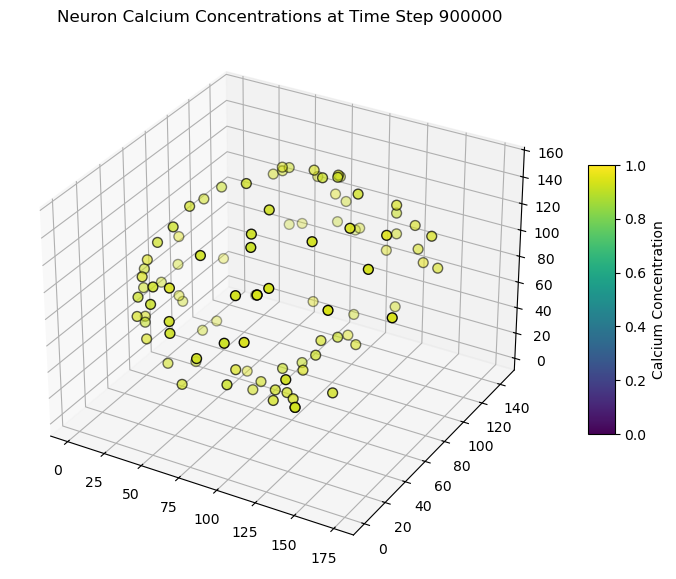

In [14]:
# Specify the time step to visualize
time_point = 900000
df_calcium_at_time = df_calcium[df_calcium['step'] == time_point]

# Merge position and calcium data
df_merged = pd.merge(df_pos, df_calcium_at_time, left_on='local id', right_on='neuron_id')

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Normalize calcium concentration for coloring
global_min = df_calcium['calcium'].min()  # Use global min and max for consistent coloring
global_max = df_calcium['calcium'].max()
calcium_values = df_merged['calcium']
colors = plt.cm.viridis((calcium_values - global_min) / (global_max - global_min))

scatter = ax.scatter(
    df_merged['pos x'], df_merged['pos y'], df_merged['pos z'],
    c=colors, s=50, cmap='viridis', edgecolor='k'
)

cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Calcium Concentration')

ax.set_title(f'Neuron Calcium Concentrations at Time Step {time_point}')

plt.show()

# Neuron calcium concentrations plot using VTK

In [12]:
# Specify the time step to visualize
time_point = 10000  # Replace with your desired time step

# Filter data for the specified time point
df_calcium_at_time = df_calcium[df_calcium['step'] == time_point]

# Merge position and calcium data
df_merged = pd.merge(df_pos, df_calcium_at_time, left_on='local id', right_on='neuron_id')

# Normalize calcium concentration for coloring
global_min = df_calcium['calcium'].min()  # Use global range
global_max = df_calcium['calcium'].max()
calcium_values = df_merged['calcium']
normalized_calcium = (calcium_values - global_min) / (global_max - global_min)

# Create a VTK points object to hold neuron positions
points = vtk.vtkPoints()
for _, row in df_merged.iterrows():
    points.InsertNextPoint(row['pos x'], row['pos y'], row['pos z'])

# Create a VTK cell array to represent vertices
vertices = vtk.vtkCellArray()
for i in range(len(df_merged)):
    vertices.InsertNextCell(1)
    vertices.InsertCellPoint(i)

# Create a VTK polydata object to store the points and vertices
polydata = vtk.vtkPolyData()
polydata.SetPoints(points)
polydata.SetVerts(vertices)

# Add calcium concentration as a scalar field for coloring
calcium_array = vtk.vtkFloatArray()
calcium_array.SetName("Calcium")
for value in normalized_calcium:
    calcium_array.InsertNextValue(value)
polydata.GetPointData().SetScalars(calcium_array)

# Create a mapper and actor for visualization
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputData(polydata)
mapper.SetScalarRange(0.0, 1.0)  # Normalized range [0, 1]
mapper.SetColorModeToMapScalars()
mapper.SetScalarModeToUsePointData()
mapper.Update()

actor = vtk.vtkActor()
actor.SetMapper(mapper)

actor.GetProperty().SetPointSize(10)  # Adjust the size as needed

# Create a renderer, render window, and interactor
renderer = vtk.vtkRenderer()
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)

interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)

# Add the actor to the renderer
renderer.AddActor(actor)
renderer.SetBackground(0.1, 0.1, 0.1)  # Dark gray background

# Start the visualization
render_window.Render()
interactor.Start()